In [1]:
from qiskit import execute, Aer
from qiskit import QuantumCircuit, QuantumRegister

from qiskit.providers import JobStatus
from qiskit.tools.qi.qi import partial_trace
from qiskit.quantum_info import state_fidelity
from qiskit.compiler import transpile
from qiskit.quantum_info.random.utils import random_state

import time

from pairwise_tomography.pairwise_state_tomography_circuits import pairwise_state_tomography_circuits
from pairwise_tomography.pairwise_fitter import PairwiseStateTomographyFitter
from pairwise_tomography.utils import concurrence

backend = Aer.get_backend('qasm_simulator')

We create a QuantumCircuit

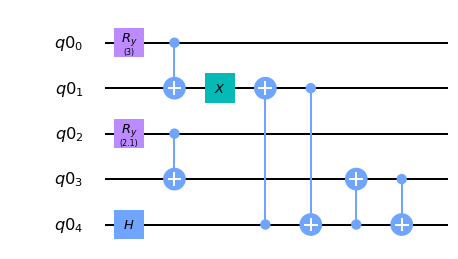

In [2]:
nq = 5

q = QuantumRegister(nq)
qc = QuantumCircuit(q)

qc.ry(3., q[0])
qc.cx(q[0], q[1])
qc.x(q[1])
qc.ry(2.1, q[2])
qc.cx(q[2], q[3])
qc.h(q[4])
qc.cx(q[4], q[1])
qc.cx(q[1], q[4])
qc.cx(q[4], q[3])
qc.cx(q[3], q[4])

qc.draw(output='mpl')

We now prepare the circuits for the pairwise tomography for all the qubits

In [3]:
pw_tomo_circs = pairwise_state_tomography_circuits(qc, q)

In [4]:
print(len(pw_tomo_circs))

15


Notice that we only need to run 15 measurement circuits

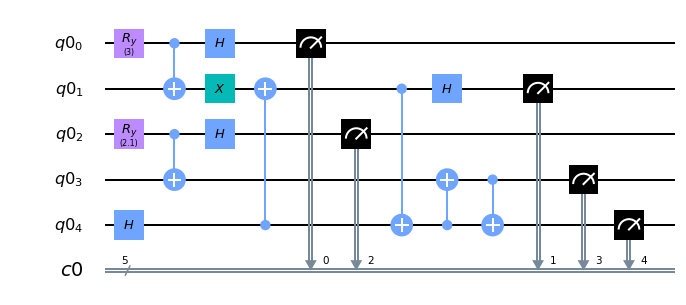

In [5]:
pw_tomo_circs[10].draw(output='mpl')

In [6]:
job = execute(pw_tomo_circs, Aer.get_backend('qasm_simulator'), shots=8192)

In [7]:
fitter = PairwiseStateTomographyFitter(job.result(), pw_tomo_circs, q)

In [8]:
fit_result = fitter.fit()

The result of `fit()` is a dictionary containing the reconstructed two-qubit density matrices for all pairs of qubits required.

```
{(i, j) : rho(i,j)}
```

You can specify the pairs of qubits you are interested in by passing a list of pairs, eg 
```
fit_result = fitter.fit([(0, 1), (1, 2) , (0, 2)])
```

In [9]:
print(fit_result[(0,1)])

[[ 2.48772817e-03+0.j          1.81979920e-03+0.00223159j
   2.88605696e-03-0.0003129j   2.10974100e-03+0.00191166j]
 [ 1.81979920e-03-0.00223159j  4.93020345e-01+0.j
  -3.12622465e-04+0.00019737j  4.96988248e-01+0.00192971j]
 [ 2.88605696e-03+0.0003129j  -3.12622465e-04-0.00019737j
   3.41546503e-03+0.j          6.12151168e-05-0.00056757j]
 [ 2.10974100e-03-0.00191166j  4.96988248e-01-0.00192971j
   6.12151168e-05+0.00056757j  5.01076462e-01+0.j        ]]


### Example: pairwise entanglement

Here we show an application: the evaluation of pairwise entanglement, and visualization of the entanglement graph

In [10]:
pairwise_entanglement = {key: concurrence(value) for key, value in fit_result.items()}

In [11]:
print(pairwise_entanglement)

{(0, 1): 0.007343418540651398, (0, 2): 0.0, (0, 3): 0.047502053502450875, (0, 4): 0.0, (1, 2): 0.0030012486212765916, (1, 3): 0.006990839409109894, (1, 4): 0.012078866090967514, (2, 3): 0.006902700256374628, (2, 4): 0.003965791344391567, (3, 4): 0.0}


In [12]:
from pairwise_tomography.visualization import draw_entanglement_graph

{0: array([1.00000000e+00, 2.38418583e-08]), 1: array([0.30901696, 0.95105658]), 2: array([-0.80901709,  0.58778522]), 3: array([-0.80901698, -0.58778535]), 4: array([ 0.30901711, -0.95105647])}


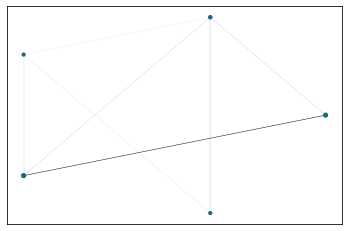

In [13]:
draw_entanglement_graph(pairwise_entanglement)